In [1]:
%pylab inline 
import pickle
import tensorflow_addons as tfa
import tensorflow as tf
import flowpm
from flowpm.tfpower import linear_matter_power
import DifferentiableHOS as DHOS
from itertools import cycle

Populating the interactive namespace from numpy and matplotlib


In [2]:
from nbodykit.cosmology import Cosmology
from nbodykit.cosmology.power.halofit import HalofitPower
from astropy.cosmology import Planck15
import astropy.units as u
from flowpm import tfpm
from flowpm.utils import cic_paint, compensate_cic
from flowpm.tfpower import linear_matter_power
from functools import partial

In [3]:
# Loads PGD parameters
with open('/global/u1/d/dlan/DifferentiableHOS/notebooks/results_fit_PGD_205_128.pkl', "rb") as f:
    pgd_data = pickle.load(f)
    pgdparams = pgd_data['params']

In [4]:
# Below are a few parameters
n_lens = 11       # Number of lensplanes in the lightcone
box_size = 205.   # Transverse comoving size of the simulation volume
nc = 128          # Number of transverse voxels in the simulation volume
field_size = 5    # Size of the lensing field in degrees
field_npix = 1024 # Number of pixels in the lensing field
batch_size = 1    # Number of simulations to run in parallel
z_source = np.array([1.]) # We'll be using a single redshift for now

In [5]:
# Instantiates a cosmology with desired parameters
cosmology = flowpm.cosmology.Planck15()
# Schedule the center of the lensplanes we want for ray tracing
r = tf.linspace(0., box_size*n_lens, n_lens+1)
r_center = 0.5*(r[1:] + r[:-1])
# Retrieve the scale factor corresponding to these distances
a = flowpm.tfbackground.a_of_chi(cosmology, r)
a_center =flowpm.tfbackground.a_of_chi(cosmology, r_center)
# We run 4 steps from initial scale factor to start of raytracing
init_stages = tf.linspace(0.1, a[-1], 4)
# Then one step per lens plane
stages = tf.concat([init_stages, a_center.numpy()[::-1]], axis=0)

In [6]:
#Create some initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                         [box_size, box_size, box_size], 
                                         lambda k: tf.cast(linear_matter_power(cosmology, k), tf.complex64),         
                                         batch_size=batch_size)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)

In [7]:
# Run the Nbody
states = flowpm.nbody(cosmology, 
                      initial_state, 
                      stages,
                      [nc, nc, nc],
                      return_intermediate_states=True,
                      pgdparams=pgdparams) 

In [8]:
%%time
# Extract the lensplanes
lensplanes = []
matrix = flowpm.raytracing.rotation_matrices()
for i, j in zip(range(len(a_center)), cycle(range(6))):
    plane = flowpm.raytracing.density_plane(states[::-1][i][1],
                                            [nc, nc, nc],
                                            nc//2,
                                            width=nc,
                                            plane_resolution=2048,
                                            rotation=matrix[j],
                                            shift=flowpm.raytracing.random_2d_shift())
    lensplanes.append((r_center[i], states[::-1][i][0], plane))

CPU times: user 24.2 s, sys: 14.1 s, total: 38.3 s
Wall time: 11 s


In [9]:
def make_power_map(power_spectrum, size, kps=None):
  #Ok we need to make a map of the power spectrum in Fourier space
  k1 = np.fft.fftfreq(size)

  k2 = np.fft.fftfreq(size)
 
  kcoords = np.meshgrid(k1,k2)
 
  # Now we can compute the k vector
  k = np.sqrt(kcoords[0]**2 + kcoords[1]**2)
 
  if kps is None:
    kps = np.linspace(0,0.5,len(power_spectrum))
  # And we can interpolate the PS at these positions
 
  ps_map = np.interp(k.flatten(), kps, power_spectrum).reshape([size,size])
 
  ps_map = tf.cast(ps_map,dtype=tf.float32)
  return ps_map

In [10]:
from scipy.stats import norm
def fourier_smoothing(im, sigma,resolution):
  kps = np.linspace(0,0.5,resolution)
  filter=norm(0, 1./(2.*np.pi*sigma)).pdf(kps)
  m = make_power_map(filter, resolution, kps=kps)
  m /= m[0,0]
  im = tf.cast(tf.reshape(m, [1, resolution, resolution]), tf.complex64) * im
  return im

In [44]:
tidal_planes=[]
def tidal_field(lensplanes,resolution,sigma):
    k = np.fft.fftfreq(resolution)
    kx, ky = np.meshgrid(k, k)
    k2 = kx**2 + ky**2
    k2[0,0] = 1.
    sxx=2*np.pi*(kx*kx/k2 -1./3)
    sxx[0,0] = 0.
    syy=2*np.pi*(ky*ky/k2 -1./3)
    syy[0,0] = 0.
    sxy=2*np.pi*(kx*ky/k2 -1./3)
    sxy[0,0] = 0.
    ss=tf.stack([sxx,syy,sxy],axis=0)
    for r,a, p in lensplanes:
        ftt_lensplane=flowpm.utils.r2c2d(p)
        ss=tf.cast(ss,dtype=tf.complex64)*ftt_lensplane
        ss=fourier_smoothing(tf.signal.fftshift(ss),sigma,resolution)
        iss=flowpm.utils.c2r2d(tf.signal.ifftshift(ss))
        tidal_planes.append(iss)
    return tidal_planes
        

In [45]:
plane_resolution=2048

We are using a two-dimensional Gaussian filter with σG = 0.1Mpc/h according to https://arxiv.org/pdf/2107.08041.pdf

In [46]:
sigma=0.1 #Mpc/h

In [47]:
tidal_planes=tidal_field(lensplanes,plane_resolution,sigma)

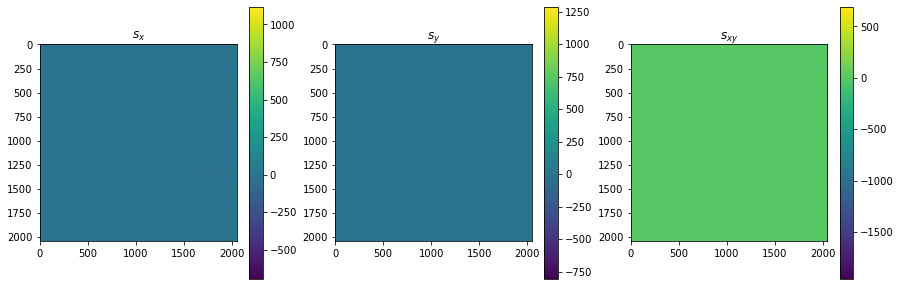

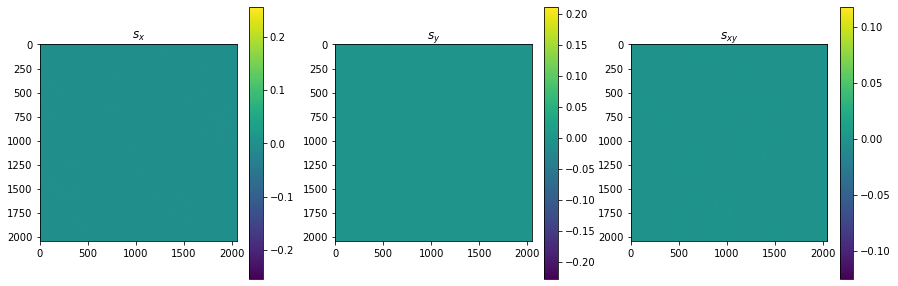

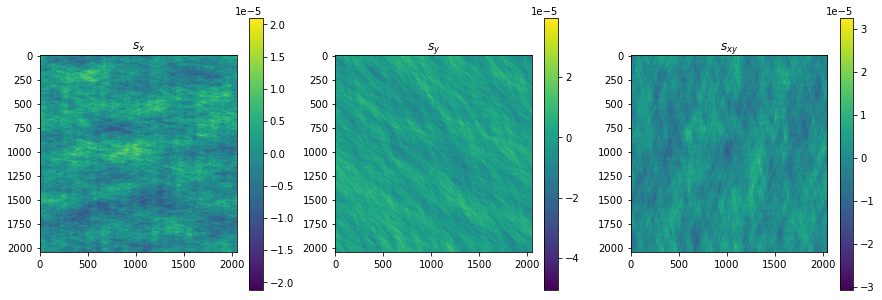

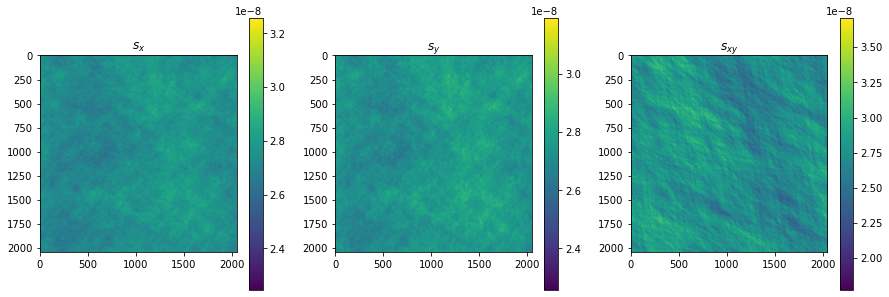

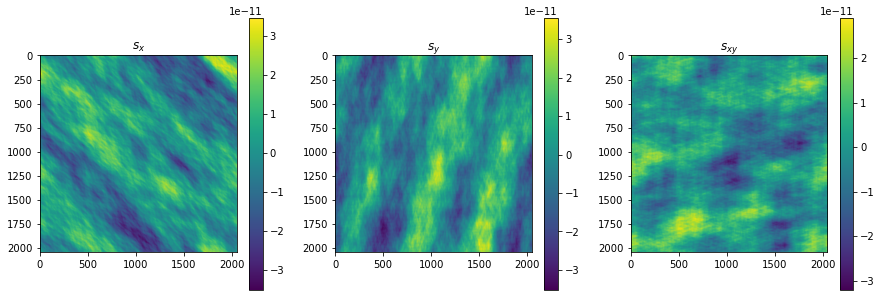

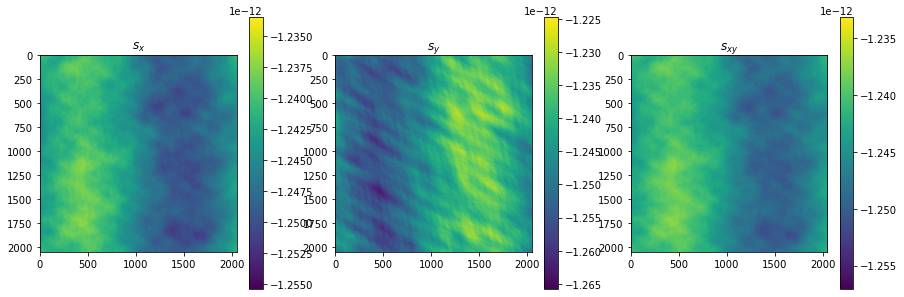

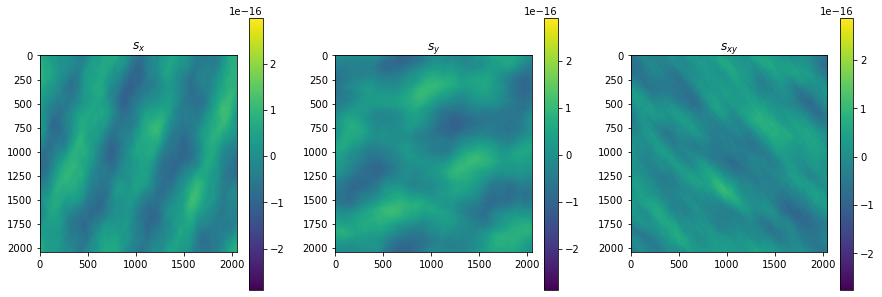

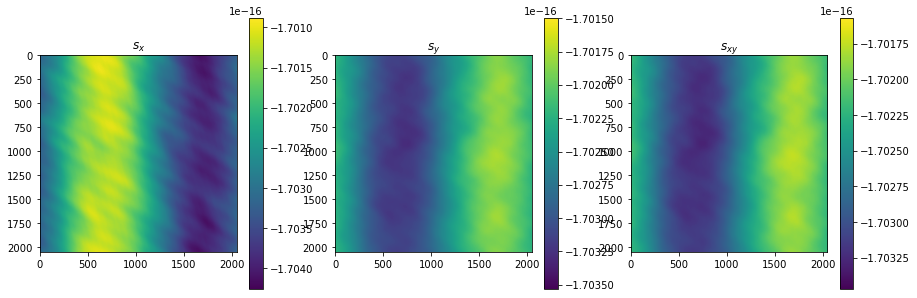

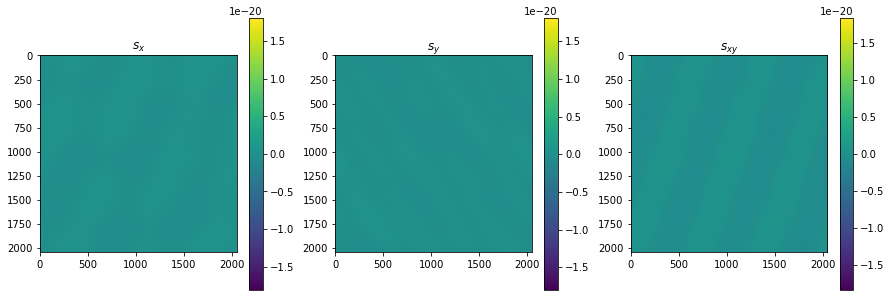

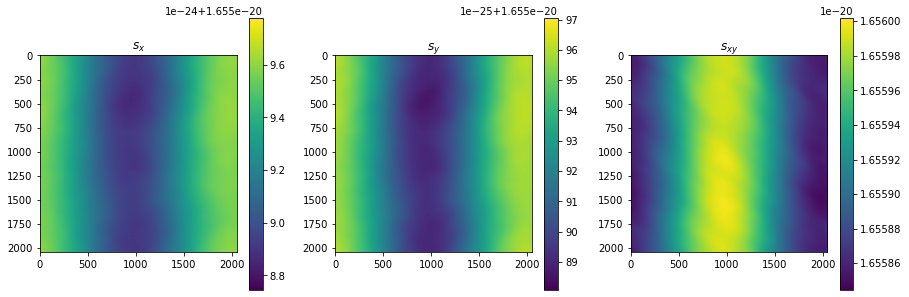

In [48]:
for i in range(10):
    figure(figsize=[15,5])
    subplot(131)
    imshow(tidal_planes[i][0])
    title('$s_x$')
    colorbar()
    subplot(132)
    imshow(tidal_planes[i][1])
    title('$s_y$')
    colorbar()
    subplot(133)
    imshow(tidal_planes[i][2])
    title('$s_{xy}$');
    colorbar()

In [49]:

import astropy.units as u
xgrid, ygrid = np.meshgrid(np.linspace(0, field_size,plane_resolution, endpoint=False), # range of X coordinates
                           np.linspace(0, field_size, plane_resolution, endpoint=False)) # range of Y coordinates

coords = np.stack([xgrid, ygrid], axis=0)*u.deg
c = coords.reshape([2, -1]).T.to(u.rad)
imm=[]
def interpolation(tidal_planes,lensplanes,
                    dx,
                    dz,
                    coords):

    coords = tf.convert_to_tensor(coords, dtype=tf.float32)
    for s,l in zip(tidal_planes,lensplanes):
        r,a,p=l


        c = coords * r / dx

        # Applying periodic conditions on lensplane
        shape = tf.shape(p)
        c = tf.math.mod(c, tf.cast(shape[1], tf.float32))

        # Shifting pixel center convention
        c = tf.expand_dims(c, axis=0) - 0.5

        im = tfa.image.interpolate_bilinear(
          tf.expand_dims(s, -1), c, indexing='xy')
        imx,imy,imxy=im
        imx=tf.reshape(imx,[plane_resolution,plane_resolution])
        imy=tf.reshape(imy,[plane_resolution,plane_resolution])
        imxy=tf.reshape(imxy,[plane_resolution,plane_resolution])
        im=tf.stack([imx,imy,imxy],axis=0)
        imm.append(im) 
    return imm

In [50]:
imm=interpolation(tidal_planes,lensplanes,dx=box_size/2048,dz=box_size,coords=c)

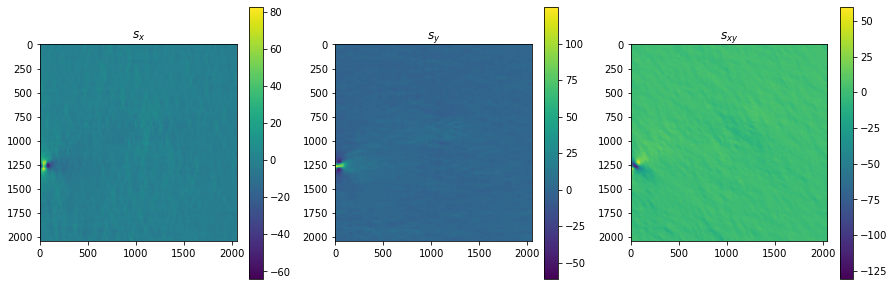

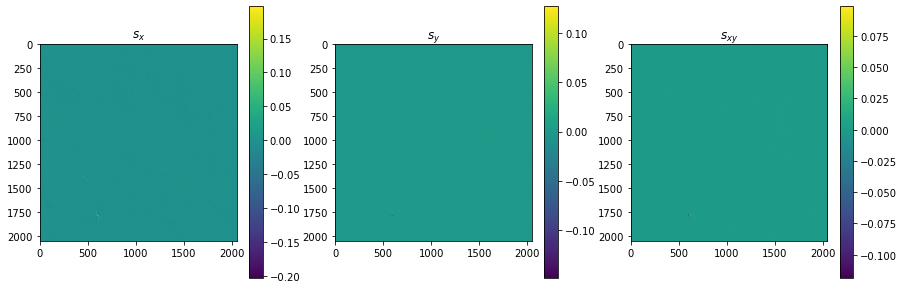

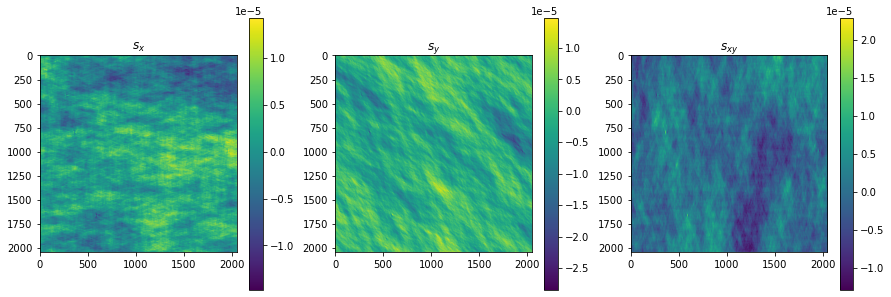

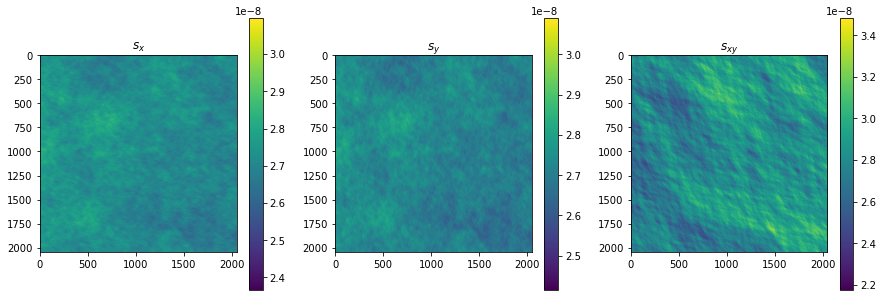

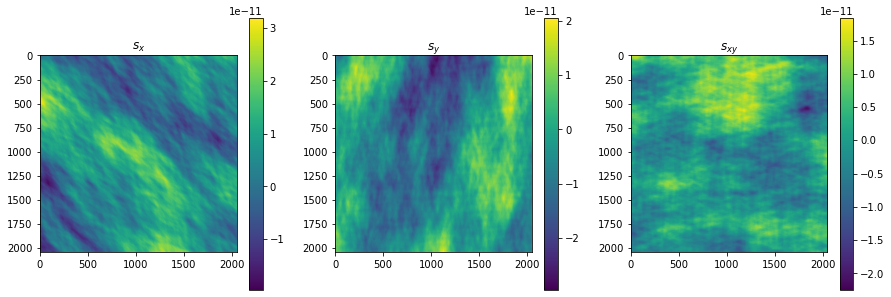

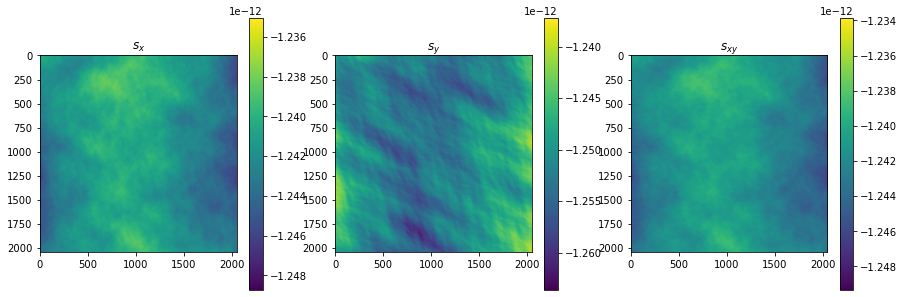

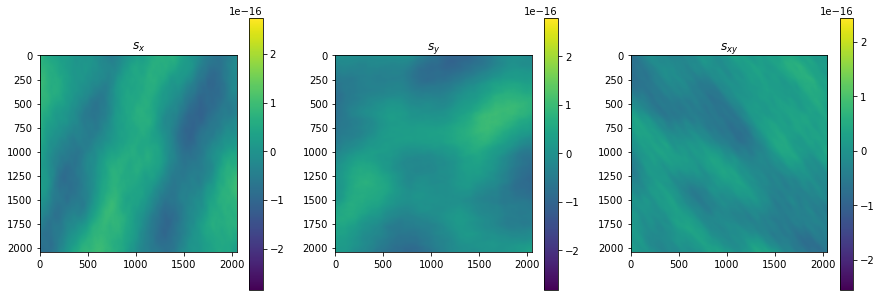

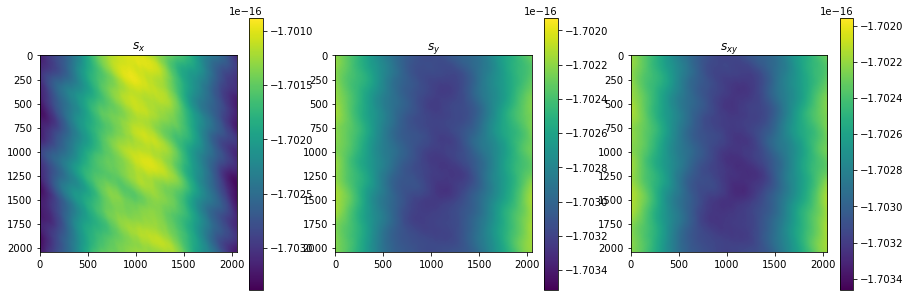

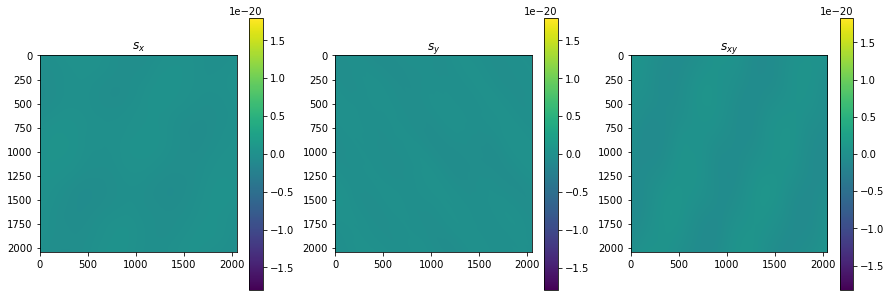

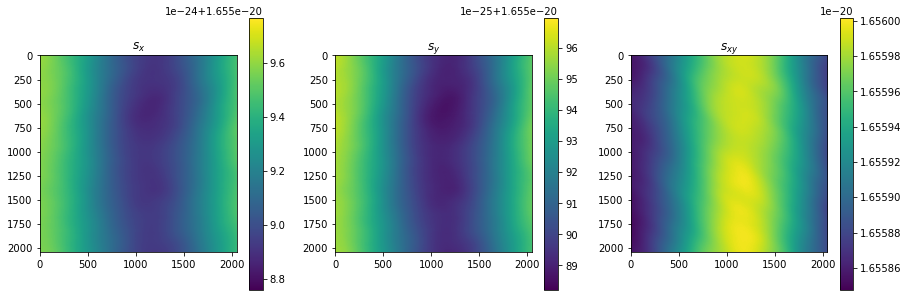

In [51]:
for i in range(10):
    figure(figsize=[15,5])
    subplot(131)
    imshow(imm[i][0])
    title('$s_x$')
    colorbar()
    subplot(132)
    imshow(imm[i][1])
    title('$s_y$')
    colorbar()
    subplot(133)
    imshow(imm[i][2])
    title('$s_{xy}$');
    colorbar()

In [52]:
imx=0
imy=0
imxy=0
for i in range(len(lensplanes)):
    imx=imx+imm[i][0]
    imy=imy+imm[i][1]
    imxy=imxy+imm[i][2]

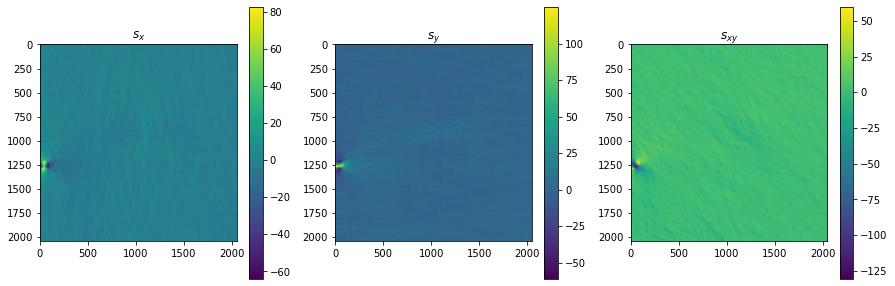

In [53]:
figure(figsize=[15,5])
subplot(131)
imshow(imx)
title('$s_x$')
colorbar()
subplot(132)
imshow(imy)
title('$s_y$')
colorbar()
subplot(133)
imshow(imxy)
title('$s_{xy}$');
colorbar()